In [ ]:
# importing and installing required libraries
!pip install kaleido
!pip install autokeras
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt
print(tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from pandas.tseries.holiday import (
    AbstractHolidayCalendar, Holiday, DateOffset, EasterMonday, GoodFriday, MO, next_monday, next_monday_or_tuesday
)
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import AbstractHolidayCalendar, nearest_workday, Easter
from pandas.tseries.offsets import  CustomBusinessDay
from sklearn.linear_model import RidgeCV
import numpy as np
import seaborn as sns
import scipy.stats as st

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [ ]:
# Calendar Rules for filtering the dataset into differnt feature space

class MyCustomCalendar(AbstractHolidayCalendar):
    rules = [Holiday("christmasweek", month=12, day=24),Holiday("christmasweek", month=12, day=25), Holiday("christmasweek", month=12, day=26), Holiday("christmasweek", month=12, day=27),
             Holiday("christmasweek", month=12, day=28), Holiday("christmasweek", month=12, day=29), Holiday("christmasweek", month=12, day=30), Holiday("christmasweek", month=12, day=31), Holiday("christmasweek", month=1, day=1) , Holiday("easterweek",month=1 , day=1, offset= [Easter()])]

cal = MyCustomCalendar()
holidays = cal.holidays(start='2015-01-01', end='2018-12-31')

In [ ]:
# Filtering the dataset by plucking different data frames as per requirement

original_train = pd.read_csv('train.csv')
original_train['Week_Number'] = pd.to_datetime(original_train['date']).dt.isocalendar().week
original_train['Month_Number'] = pd.to_datetime(original_train['date']).dt.month
original_train['Year_Number'] = pd.to_datetime(original_train['date']).dt.year
original_train['day'] = pd.to_datetime(original_train['date']).dt.day
# original_train['day_month'] = original_train['day'].astype(str) + "_" +original_train['Month_Number'].astype(str)
original_train.head(n=600)
# px.histogram(original_train, x='Week_Number', y='num_sold', color="country", barmode="group").show()
# px.histogram(original_train, x='day', y='num_sold', color="country", barmode="group", facet_row="Month_Number",facet_col="Year_Number",width=1400, height=2000).show()

,row_id,date,country,store,product,num_sold,Week_Number,Month_Number,Year_Number,day
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,1,1,2015,1
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,1,1,2015,1
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,1,1,2015,1
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,1,1,2015,1
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,1,1,2015,1
...,...,...,...,...,...,...,...,...,...,...
595,595,2015-02-03,Finland,KaggleMart,Kaggle Hat,305,6,2,2015,3
596,596,2015-02-03,Finland,KaggleMart,Kaggle Sticker,87,6,2,2015,3
597,597,2015-02-03,Finland,KaggleRama,Kaggle Mug,305,6,2,2015,3
598,598,2015-02-03,Finland,KaggleRama,Kaggle Hat,588,6,2,2015,3


In [ ]:
# One hot encoding for categorical values to dampen the effect of large and complex multiplications

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1) #.drop([each], axis=1)
    return df
ohe_train = one_hot(original_train,['Week_Number', 'product', 'store', 'country'])
ohe_train = ohe_train.drop(['Week_Number', 'product', 'store', 'country', 'date', 'row_id'], axis=1)
new_train = ohe_train[ohe_train['Year_Number'] < 2018]
new_test = ohe_train[ohe_train['Year_Number'] == 2018]
new_train = new_train.drop(['Year_Number'],axis=1)
new_test = new_test.drop(['Year_Number'],axis=1)
new_train.head()

,num_sold,Month_Number,day,Week_Number_1,Week_Number_2,Week_Number_3,Week_Number_4,Week_Number_5,Week_Number_6,Week_Number_7,...,Week_Number_52,Week_Number_53,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker,store_KaggleMart,store_KaggleRama,country_Finland,country_Norway,country_Sweden
0,329,1,1,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
1,520,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,146,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,572,1,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,911,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0


In [ ]:
# Train Test Validation split
train_split, validation_split = train_test_split(new_train, test_size=0.2, random_state=123)

In [ ]:
# Feature Engineering

x = train_split.drop('num_sold', axis=1)
y = train_split['num_sold']

# clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5, 10]).fit(x, y)
# clf.score(x, y)

x_tensor = tf.convert_to_tensor(x)
y_tensor = tf.convert_to_tensor(y)


# Declaring and defing the model with 1 layer, simplest example to try

tf_linear_model = tf.keras.Sequential([layers.Dense(units=1)])
tf_linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history = tf_linear_model.fit(
    x_tensor ,
    y_tensor,
    epochs=100,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
395/395 - 2s - loss: 210.7177 - val_loss: 179.3660 - 2s/epoch - 4ms/step
Epoch 2/100
395/395 - 1s - loss: 160.8653 - val_loss: 146.2500 - 613ms/epoch - 2ms/step
Epoch 3/100
395/395 - 1s - loss: 128.8317 - val_loss: 117.9148 - 607ms/epoch - 2ms/step
Epoch 4/100
395/395 - 1s - loss: 104.6607 - val_loss: 99.1426 - 1s/epoch - 3ms/step
Epoch 5/100
395/395 - 1s - loss: 89.7998 - val_loss: 88.4362 - 1s/epoch - 3ms/step
Epoch 6/100
395/395 - 1s - loss: 81.4888 - val_loss: 82.9619 - 1s/epoch - 3ms/step
Epoch 7/100
395/395 - 1s - loss: 77.4175 - val_loss: 80.3657 - 1s/epoch - 3ms/step
Epoch 8/100
395/395 - 1s - loss: 75.5959 - val_loss: 79.1161 - 1s/epoch - 3ms/step
Epoch 9/100
395/395 - 1s - loss: 74.6979 - val_loss: 78.5283 - 1s/epoch - 3ms/step
Epoch 10/100
395/395 - 1s - loss: 74.2281 - val_loss: 78.3266 - 1s/epoch - 4ms/step
Epoch 11/100
395/395 - 1s - loss: 74.0353 - val_loss: 77.9991 - 1s/epoch - 3ms/step
Epoch 12/100
395/395 - 1s - loss: 73.8113 - val_loss: 77.9438 - 1s/epoch

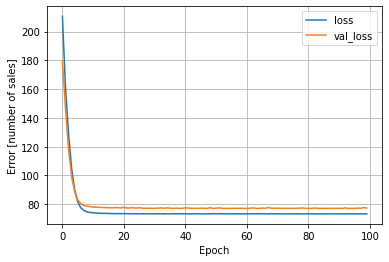

In [ ]:
# Plotting the curve

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [number of sales]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
# How well that particular feature is resembling with ground truth, in other words

validation_x = validation_split.drop(['num_sold'], axis=1)
validation_y = validation_split['num_sold']

validation_x_tensor = tf.convert_to_tensor(validation_x)
validation_y_tensor = tf.convert_to_tensor(validation_y)


test_results = {
    'linear_model_val': tf_linear_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0),
    'linear_model_train': tf_linear_model.evaluate(x_tensor, y_tensor, verbose=0)
    }
test_results


# Printing Accuracy / Goodness of Fit
print(test_results)
# tf_linear_model.layers[0].kernel

{'linear_model_val': 74.59557342529297, 'linear_model_train': 74.14871215820312}


In [ ]:
def build_and_compile_model(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model = keras.Sequential([
      layers.Dense(hp_units, activation='relu'),
      layers.Dense(hp_units, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(hp_learning_rate))
  return model

def build_and_compile_dnn_model():
  model = keras.Sequential([
      layers.Dense(352, activation='relu'),
      layers.Dense(352, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))
  return model


def build_and_compile_adagrad_model():
  model = keras.Sequential([
      layers.Dense(352, activation='relu'),
      layers.Dense(352, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
  return model




def build_and_compile_sgd_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))
  return model

def optimized_dnn_model():
  model = keras.Sequential([
      layers.Dense(352, activation='relu'),
      layers.Dense(352, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

def l2_regularized_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def l2_regularized_and_dropout_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
# HyperParameter Tuning / Grid Search

tuner = kt.Hyperband(build_and_compile_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(x_tensor, y_tensor, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 12s]
val_loss: 70.87539672851562

Best val_loss So Far: 39.87720489501953
Total elapsed time: 00h 05m 14s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.001.



CPU times: user 3min 29s, sys: 16.1 s, total: 3min 45s
Wall time: 3min 22s


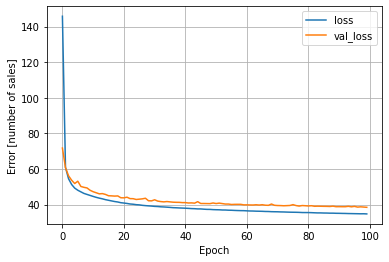

In [ ]:

%%time
adagrad_model =build_and_compile_adagrad_model()
adagrad_history = adagrad_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(adagrad_history)

CPU times: user 3min 22s, sys: 15.6 s, total: 3min 37s
Wall time: 3min 22s


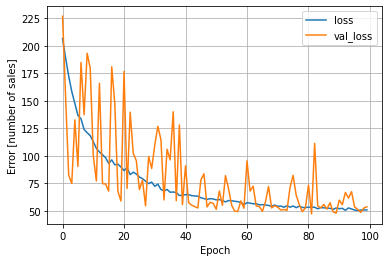

In [ ]:
%%time
dnn_model = build_and_compile_dnn_model()
history = dnn_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history)

CPU times: user 1min 16s, sys: 4.88 s, total: 1min 21s
Wall time: 1min 9s


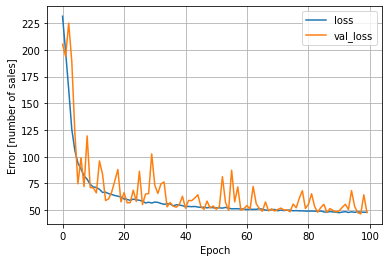

In [ ]:
%%time
sgd_dnn_model = build_and_compile_sgd_model()
sgd_history = sgd_dnn_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(sgd_history)

CPU times: user 3min 34s, sys: 15.8 s, total: 3min 50s
Wall time: 2min 46s


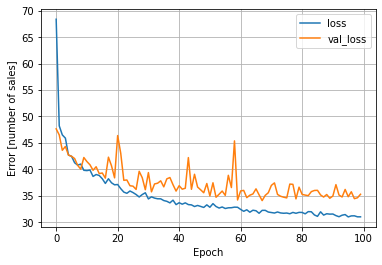

In [ ]:
%%time
optimized_dnn_model = optimized_dnn_model() # Adam
optimized_history = optimized_dnn_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(optimized_history)

CPU times: user 1min 35s, sys: 6.39 s, total: 1min 41s
Wall time: 1min 22s


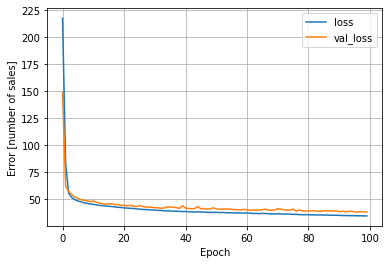

In [ ]:
%%time
l2_dnn_model = l2_regularized_model()
l2_history = l2_dnn_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(l2_history)

CPU times: user 1min 41s, sys: 6.88 s, total: 1min 47s
Wall time: 2min 22s


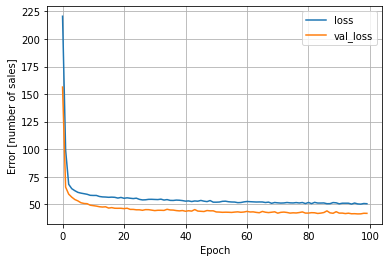

In [ ]:
%%time
l2_dropout_dnn_model = l2_regularized_and_dropout_model()
l2_dropout_history = l2_dropout_dnn_model.fit(
    x_tensor,
    y_tensor,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(l2_dropout_history)

In [ ]:
test_results['dnn_model_train'] = dnn_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['dnn_model_val'] = dnn_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)
test_results['l2_dnn_model_train'] = l2_dnn_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['l2_dnn_model_val'] = l2_dnn_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)
test_results['l2_dropout_dnn_model_train'] = l2_dropout_dnn_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['l2_dropout_dnn_model_val'] = l2_dropout_dnn_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)
test_results['optimized_dnn_model_train'] = optimized_dnn_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['optimized_dnn_model_val'] = optimized_dnn_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)
test_results['sgd_dnn_model_train'] = sgd_dnn_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['sgd_dnn_model_val'] = sgd_dnn_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)

test_results['adagrad_dnn_model_train'] = adagrad_model.evaluate(x_tensor, y_tensor, verbose=0)
test_results['adagrad_dnn_model_val'] = adagrad_model.evaluate(validation_x_tensor, validation_y_tensor, verbose=0)


# As the results look like, we can say, Optimised DNN > L2 DNN > L2+Dropout DNN > SGD DNN > Vanilla DNN > Linear Model
# Optimised Model - contains fine tuned hyper parameters

In [ ]:
val_predictions = optimized_dnn_model.predict(validation_x_tensor).flatten()
px.scatter(x = validation_y_tensor, y = val_predictions).show()
val_predictions

124/124 [==============================] - 0s 2ms/step


array([353.372  , 199.90746, 187.11838, ..., 189.77289, 717.1186 ,
       552.41504], dtype=float32)

In [ ]:
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt
px.scatter(x = validation_y_tensor, y = val_predictions, color=val_predictions).show()
# Less divergence Yellow / More Convergence Purple
# Infer - As color turns yellow, we see divergence
# Infer - As color turns Violet, we see convergence

In [ ]:
# R square evaluation mteric on validation
import sklearn.metrics as metrics

metrics.r2_score(validation_y_tensor, val_predictions)

0.9420644495651558

In [ ]:
# Performing Analysis on Test dataset
# Test dataset is named as new_test

x = new_test.drop('num_sold', axis=1) # data
y = new_test['num_sold'] # ground truth / analog to labels in classification

In [ ]:
# Using the best model optimised_DNN_model for predictions values

y_pred = optimized_dnn_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
px.scatter(x = y, y = y_pred_resized, color=y).show()
fig_cd = px.scatter(x = y, y = y_pred_resized, color=y)
fig_cd.write_image("Convergence_Divergence.pdf")

206/206 [==============================] - 0s 2ms/step


In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data - Optimized_dnn_model

metrics.r2_score(y, y_pred_resized)

0.8818440148426218

In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data - dnn_model

y_pred = dnn_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
metrics.r2_score(y, y_pred_resized)

206/206 [==============================] - 1s 2ms/step


0.7598325067067018

In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data - l2_dnn_model

y_pred = l2_dnn_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
metrics.r2_score(y, y_pred_resized)

206/206 [==============================] - 1s 3ms/step


0.8794640971797687

In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data - l2_dropout_dnn_model
y_pred = l2_dropout_dnn_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
metrics.r2_score(y, y_pred_resized)

206/206 [==============================] - 1s 3ms/step


0.8385437888849032

In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data -  sgd_dnn_model

y_pred = sgd_dnn_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
metrics.r2_score(y, y_pred_resized)

206/206 [==============================] - 1s 3ms/step


0.8468553590978601

In [ ]:
# R square evaluation mteric / Goodness of Fit on test and prediction data -  adagrad_model

y_pred = adagrad_model.predict(x)
y_pred_resized = y_pred.reshape(6570,)
metrics.r2_score(y, y_pred_resized)

206/206 [==============================] - 1s 3ms/step


0.857444463238099

In [ ]:
test_results['dnn_model_train'] = dnn_model.evaluate(x,y, verbose=0)
test_results['dnn_model_val'] = dnn_model.evaluate(x,y, verbose=0)
test_results['l2_dnn_model_train'] = l2_dnn_model.evaluate(x,y, verbose=0)
test_results['l2_dnn_model_val'] = l2_dnn_model.evaluate(x,y, verbose=0)
test_results['l2_dropout_dnn_model_train'] = l2_dropout_dnn_model.evaluate(x,y, verbose=0)
test_results['l2_dropout_dnn_model_val'] = l2_dropout_dnn_model.evaluate(x,y, verbose=0)
test_results['optimized_dnn_model_train'] = optimized_dnn_model.evaluate(x,y, verbose=0)
test_results['optimized_dnn_model_val'] = optimized_dnn_model.evaluate(x,y, verbose=0)
test_results['sgd_dnn_model_train'] = sgd_dnn_model.evaluate(x,y, verbose=0)
test_results['sgd_dnn_model_val'] = sgd_dnn_model.evaluate(x,y, verbose=0)
test_results['adagrad_dnn_model_train'] = adagrad_model.evaluate(x,y, verbose=0)
test_results['adagrad_dnn_model_val'] = adagrad_model.evaluate(x,y, verbose=0)

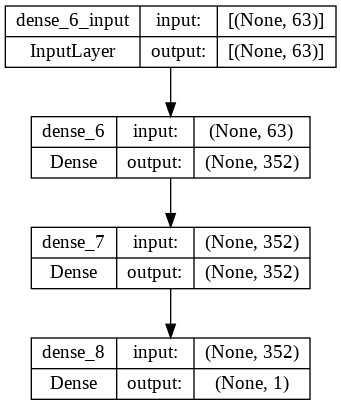

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(dnn_model, to_file='model_plot_dnn_model.png',show_shapes=True, show_layer_names=True)

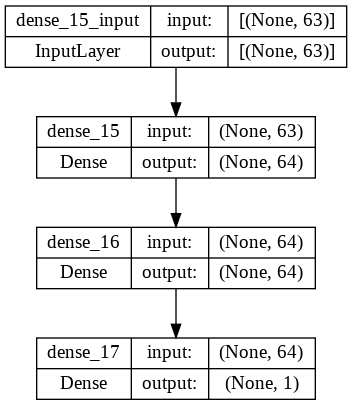

In [ ]:

plot_model(l2_dnn_model, to_file='model_plot_l2_dnn_model.png',show_shapes=True, show_layer_names=True)

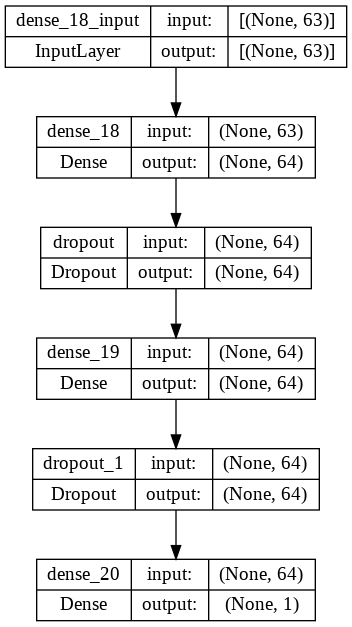

In [ ]:

plot_model(l2_dropout_dnn_model, to_file='model_plot_l2_dropout_dnn_model.png',show_shapes=True, show_layer_names=True)

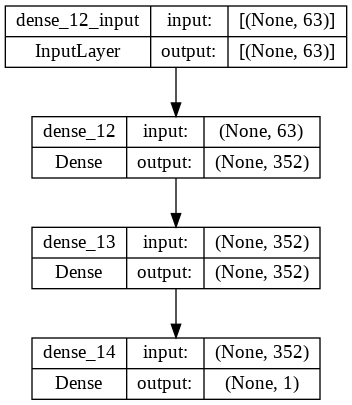

In [ ]:

plot_model(optimized_dnn_model, to_file='model_plot_optimized_dnn_model.png',show_shapes=True, show_layer_names=True)

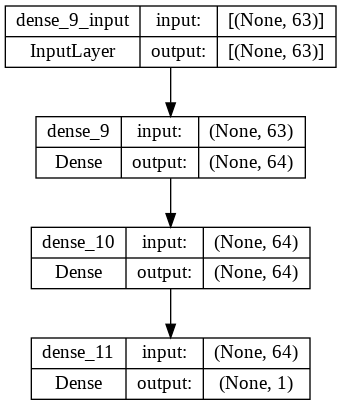

In [ ]:

plot_model(sgd_dnn_model, to_file='model_plot_sgd_dnn_model.png',show_shapes=True, show_layer_names=True)

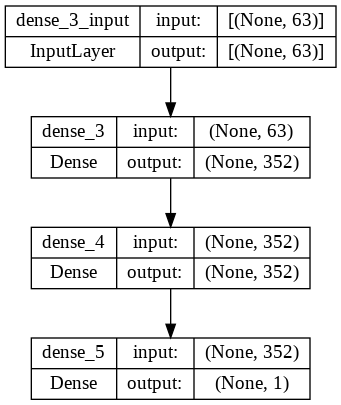

In [ ]:

plot_model(adagrad_model, to_file='model_plot_adagrad_model.png',show_shapes=True, show_layer_names=True)

In [ ]:
# Radar Plot

# Ground truth - Test dataset for number of items sold - y
# Predicted values - Predicted values of the num.... - y_pred_resized

import plotly.graph_objects as go

categories = ['20', '40', '60', '80', '100', '120', '140', '160', '180', '200','220','240','260','280','300','320','340','360']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=np.array(y),
      theta=categories,
      fill='toself',
      name='Test Dataset'
))
fig.add_trace(go.Scatterpolar(
      r=np.array(y_pred_resized),
      theta=categories,
      fill='toself',
      name='Predicted Dataset'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2000]
    )),
  showlegend=False
)

fig.show()
fig.write_image("20_360.pdf")

In [ ]:
# Radar Plot

# Ground truth - Test dataset for number of items sold - y
# Predicted values - Predicted values of the num.... - y_pred_resized

import plotly.graph_objects as go

categories = ['360', '400', '440', '480', '520', '560', '600', '640', '680', '720','760','800','840','880','920','960','1000','1040']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=np.array(y),
      theta=categories,
      fill='toself',
      name='Test Dataset'
))
fig.add_trace(go.Scatterpolar(
      r=np.array(y_pred_resized),
      theta=categories,
      fill='toself',
      name='Predicted Dataset'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2000]
    )),
  showlegend=False
)

fig.show()
fig.write_image("360_1040.pdf")


In [ ]:
# Radar Plot

# Ground truth - Test dataset for number of items sold - y
# Predicted values - Predicted values of the num.... - y_pred_resized

import plotly.graph_objects as go

categories = ['1040', '1080', '1120', '1160', '1200', '1240', '1280', '1320', '1360', '1400','1440','1480','1520','1560','1600','1640','1680','1720']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=np.array(y),
      theta=categories,
      fill='toself',
      name='Test Dataset'
))
fig.add_trace(go.Scatterpolar(
      r=np.array(y_pred_resized),
      theta=categories,
      fill='toself',
      name='Predicted Dataset'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2000]
    )),
  showlegend=False
)

fig.show()
fig.write_image("1040_1720.pdf")


In [ ]:
# Radar Plot

# Ground truth - Test dataset for number of items sold - y
# Predicted values - Predicted values of the num.... - y_pred_resized

import plotly.graph_objects as go

categories = ['1760', '1800', '1840', '1880', '1920', '1960', '2000', '2040', '2080', '2120','2160','2200','2240','2280','2320','2360','2400','2440']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=np.array(y),
      theta=categories,
      fill='toself',
      name='Test Dataset'
))
fig.add_trace(go.Scatterpolar(
      r=np.array(y_pred_resized),
      theta=categories,
      fill='toself',
      name='Predicted Dataset'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2000]
    )),
  showlegend=False
)

fig.show()
fig.write_image("1760-2440.pdf")


In [ ]:
# Radar Plot

# Ground truth - Test dataset for number of items sold - y
# Predicted values - Predicted values of the num.... - y_pred_resized

import plotly.graph_objects as go

categories = ['2480', '2520', '2560', '2600', '2640', '2680', '2720', '2760', '2800', '2840','2880','2920','2960','3000']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=np.array(y),
      theta=categories,
      fill='toself',
      name='Test Dataset'
))
fig.add_trace(go.Scatterpolar(
      r=np.array(y_pred_resized),
      theta=categories,
      fill='toself',
      name='Predicted Dataset'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2000]
    )),
  showlegend=False
)

fig.show()
fig.write_image("2480_3000.pdf")


In [ ]:
# Predicted values and distribution
ypred_list = list(y_pred_resized.astype(int))
# Original values and distribution
y_groundtruth = list(np.array(y))


In [ ]:



#define sample data_predicted
data_predicted = ypred_list


print("creates 95% confidence interval for population mean number of items sold for predicted data:")
#create 95% confidence interval for population mean number of items sold
st.t.interval(alpha=0.95, df=len(data_predicted)-1, loc=np.mean(data_predicted), scale=st.sem(data_predicted)) 

creates 95% confidence interval for population mean number of items sold for predicted data:


(360.3405202096779, 371.63482225607555)

In [ ]:


#define sample data_groundtruth
data_groundtruth = y_groundtruth

print("creates 95% confidence interval for population mean number of items sold for Ground Truth data:")
#create 95% confidence interval for population mean number of items sold
st.t.interval(alpha=0.95, df=len(data_groundtruth)-1, loc=np.mean(data_groundtruth), scale=st.sem(data_groundtruth)) 


creates 95% confidence interval for population mean number of items sold for Ground Truth data:


(417.92168841438894, 432.0685703375137)

In [ ]:
x_pdf = y_pred_resized
mean = np.mean(y_pred_resized)
std = np.std(y_pred_resized)
y_pdf = norm.pdf(x_pdf, mean, std)

In [ ]:
print(x_pdf)
print(mean)
print(std)
print(y_pdf)

[348.3915  502.05978 156.37984 ... 622.4964  822.2969  370.74118]
366.4829
233.47772
[0.00170357 0.00144359 0.00113978 ... 0.00093665 0.00025411 0.00170841]


In [ ]:
from random import choice
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

mu, sigma = np.mean(y_pred_resized),np.std(y_pred_resized)
population = np.random.normal(mu, sigma, 100000)

def get_confidence_interval(variance, sample_mean, sample_size, significance_level):
    margin_of_error = norm.ppf(1 - significance_level/2)*variance/np.sqrt(sample_size)
    return sample_mean - margin_of_error, sample_mean + margin_of_error

sample_size = 100
sample = np.random.choice(population, sample_size)
sample_mean = np.average(sample)
confidence_interval = get_confidence_interval(sigma, sample_mean, sample_size, 0.05)

# xs = np.arange(20, 800, 1)
# ys = norm.pdf(xs, mu, sigma)
# plt.plot(xs, ys, label='population distribution')
# plt.plot(confidence_interval, [0.0010, 0.0025], label='confidence interval for mean')
# plt.legend()
# plt.show()

In [ ]:
confidence_interval

(324.83272445567127, 416.35430978400484)